<a href="https://colab.research.google.com/github/terentevmn/CM_Final_Assignment/blob/main/CM_Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Assignment: A Single-Layer and a Multi-Layer Perceptron

**Course**: Cognitive Modelling (2022-2023)

**Student**: Maksim Terentev (2565137)

**Description**: This notebook is the final assignment of the Cognitive Modelling course, where we will build a single-layer perceptron and look at how it performs on binary classification tasks for two simple datasets (linary separable and non-lineary separable). Moreover, we will look at a more advanced feed-forward neural network called a multi-layer perceptron. The MLP will be used to learn non-linearly separable patterns. Finally, we will look at how the MLP performs on the brain activity data (EEGBCI dataset).

**Note**: The code of this project is based on [Multi-Layer Perceptron](https://clclab.github.io/FNCM/Lab4-MLP.html).

## Setting Things up

For this project, we will need the `NumPy`, `pandas`, `Matplotlib`, `MNE`, `SciPy`, `PyWavelets`, and `scikit-learn` libraries, as well as some functions that are defined in the `MLP.py` file and some methods located in the `EEG.py` file. The cell below takes care of all of this. When the following message appears: 
```
Do you want to set the path: /root/mne_data as the default EEGBCI dataset path in the mne-python config [y]/n?
```, press `y` and then `enter`.

In [12]:
# Install missing package
!pip install mne

# Import packages
import numpy as np                     # math
import pandas as pd                    # data manipulation
import matplotlib.pyplot as plt        # plotting
import mne                             # EEG dataset
import scipy                           # scientific computing & signal processing
import pywt                            # wavelet transform
import random                          # shuffling lists
import sklearn                         # machine learning tools (feature selection)

# Download code from the FNCM github repository
!wget --no-cache {"https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/EEG.py"}
!wget --no-cache {"https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/MLP.py"}

# Import downloaded packages
import MLP
from MLP import MLP, plot_errors
import EEG
from EEG import full_epochs, cropped_epochs, EEG_imagery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-29 12:00:09--  https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/EEG.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6168 (6.0K) [text/plain]
Saving to: ‘EEG.py.2’

EEG.py.2            100%[===================>]   6.02K  --.-KB/s    in 0s      

2022-12-29 12:00:09 (45.8 MB/s) - ‘EEG.py.2’ saved [6168/6168]

--2022-12-29 12:00:09--  https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/MLP.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connecte

## Introducing Data

We will train our perceptron on logical OR and XOR datasets. The difference between those datasets is that the OR dataset is lineary separable while the XOR dataset is non-lineary separable. Both datasets are defined in the two cells below.

In [13]:
# OR data
data_OR = pd.DataFrame(data = {'x1': [1, 1, 0, 0], 
                             'x2': [1, 0, 1, 0],
                             'y': [1, 1, 1, 0]})
data_OR

,x1,x2,y
0,1,1,1
1,1,0,1
2,0,1,1
3,0,0,0


In [14]:
# XOR data
data_XOR = pd.DataFrame(data = {'x1': [1, 1, 0, 0], 
                              'x2': [1, 0, 1, 0],
                              'y': [0, 1, 1, 0]})

data_XOR

,x1,x2,y
0,1,1,0
1,1,0,1
2,0,1,1
3,0,0,0


We will construct a single-layer perceptron in the cells below and determine whether the perceptron can learn the pattern on each of datasets.

## Introducing a Single-Layer Perceptron

First, we will define an activation function. The `binary_threshold(x)` activation function will be used for the single-layer perceptron.

In [15]:
# binary threshold function
def binary_threshold(x):
    """
    Binary threshold function.
    
    Input:
      x -- an array
      
    Output:
      binary_threshold(x) = 1.0 if x > 0, else 0.0
    """
    return 1. * (x > 0)

Let us now introduce a single-layer perceptron represented through the `Perceptron` class.

In [16]:
# Perceptron model
class Perceptron:
    def __init__(self, dim, activation):
        """
        Initializes the perceptron -- sets weights, bias and
        activation function; returns the perceptron object.
        
        Input:
          dim -- dimensionality of the datapoints (integer)
          activation -- the desired activation function (function)
        """
        
        # initialize all weights and bias as zero
        self.weights = np.zeros(dim)
        self.bias = 0
        
        # activation function
        self.activation = activation
            
    def compute_error(self, X, y):
        """
        Computes the mean squared error (MSE) of the perceptron with regard 
        to the dataset.
        
        Input:
          X -- an (N, D) array in which each row is a data point
          y -- an (N, 1) array in which each row is the target of X[i,]
          
        Output:
          classification error (mean squared error)
        """
        
        # number of data points
        N = len(X)
        
        # compute mean squared error
        mse = np.sum((y.flatten() - \
                self.activation(X @ self.weights + self.bias)) ** 2) / N
        
        return mse
    
    def plot(self, X, y, example_input):
        """
        Plot the data points and the (learned) decision boundary.
        """
        targets = y.flatten()
        wmin = -1.5
        wmax = 1.5
        
        # plot data points
        plt.plot(X[targets == 1, 0], X[targets == 1, 1], 'bo', ms = 10)
        plt.plot(X[targets == 0, 0], X[targets == 0, 1], 'rs', ms = 10)
        plt.xlim(wmin, wmax)
        plt.ylim(wmin, wmax)
        plt.xticks([0, 1])
        plt.yticks([0, 1])
        plt.xlabel('$x_1$', size=15)
        plt.ylabel('$x_2$', size=15)
        
        # plot circle around current example
        plt.scatter(example_input[0], example_input[1], marker = 's',
                    color = 'none', edgecolor = 'g', s = 400)
        
        # plot decision boundary
        if perceptron.weights[0] == 0. and perceptron.weights[1] == 0:
            pass
        elif perceptron.weights[1] == 0.:
            db_y = np.arange(start = wmin, stop = wmax, step = 0.1)
            db_x = (-perceptron.bias - db_y * perceptron.weights[1]) / \
                    perceptron.weights[0]
            plt.plot(db_x, db_y, 'k-')
        else:
            db_x = np.arange(start = wmin, stop = wmax, step = 0.1)
            db_y = (-perceptron.bias - db_x * perceptron.weights[0]) / \
                    perceptron.weights[1]
            plt.plot(db_x, db_y, 'k-')
        plt.show()
    
    def train(self, X, y, epochs, learn_rate = 0.1, stepbystep = True):
        """
        Trains the perceptron -- iterates over a dataset and learns 
        online.
        
        Input:
          X -- an (N,D) array in which each row is a data point
          y -- an (N,1) array in which each row is the target of X[i,]
          epochs -- the number of epochs (iterations) for training
          learn_rate -- the learning rate for training
          stepbystep -- wait for user to continue and print each step
          
        Output:
          errors -- error over the entire data after each iteration
        """
        errors = np.zeros(epochs)
        
        for it in range(0, epochs):
            if stepbystep:
                print('iteration', it + 1)
            
            # pick training example
            i = it % len(X)
            example_input = X[i, : ]
            true_label = y[i]
            
            # update perceptron
            self.update(example_input, true_label, learn_rate, stepbystep)
            
            if stepbystep:
                self.plot(X, y, example_input)
                inpt = input()
                if inpt == 'q':
                    print('Stopped after', it + 1, 'iterations.')
                    break
            
            errors[it] = self.compute_error(X, y)
            
        return errors
    
    def update(self, example_input, true_label, learn_rate, stepbystep = True):
        """
        Applies a single update to the perceptron.
        
        Input:
          example_input -- an example datapoint (vector)
          true_label -- the corresponding label (ground truth)
          learn_rate -- the learning rate (real number)
          stepbystep -- whether to print the results
        """
        pred = self.activation(np.sum(self.weights.T * example_input + self.bias))

        self.weights = self.weights + learn_rate * (true_label - pred) * example_input
        self.bias = self.bias + learn_rate * (true_label - pred)
        
        if stepbystep:
            print('\tinput:', example_input)
            print('\ttarget:', true_label)
            print('\tprediction:', pred)
            print('\tweights:', self.weights)
            print('\tbias:', self.bias, '\n')

# Training a Single-Layer Perceptron

Let us train the perceptron on both datasets and see how it performs on each of them. 

weights: [0. 0.]
bias: 0
activation function: binary_threshold
iteration 1
	input: [1 1]
	target: [1]
	prediction: 0.0
	weights: [0.1 0.1]
	bias: [0.1] 



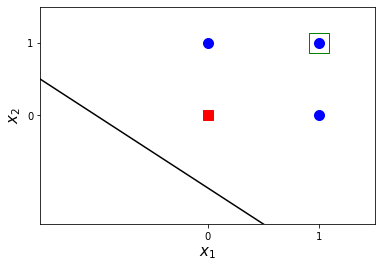


iteration 2
	input: [0 1]
	target: [1]
	prediction: 1.0
	weights: [0.1 0.1]
	bias: [0.1] 



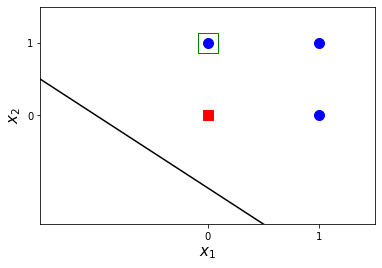


iteration 3
	input: [0 0]
	target: [0]
	prediction: 1.0
	weights: [0.1 0.1]
	bias: [0.] 



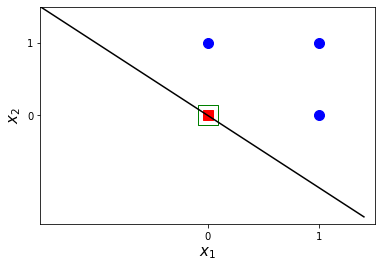

q
Stopped after 3 iterations.


array([0.25, 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  ])

In [19]:
# the data
# change between data_OR and data_XOR based on what you want to learn
data = data_OR

# shuffle data
np.random.shuffle(data.values)
X = data[['x1', 'x2']].values
y = data[['y']].values
input_size = X.shape[1]

# initialize the perceptron
perceptron = Perceptron(dim = input_size,
                        activation = binary_threshold)

# print model attributes before training
print('weights:', perceptron.weights)
print('bias:', perceptron.bias)
print('activation function:', perceptron.activation.__name__)

# train perceptron
perceptron.train(X, y,
                 epochs = 15,
                 learn_rate = 0.1,
                 stepbystep = True)

As can be seen, a single-layer perceptron can learn how to solve the logical OR problem within five iterations. However, it cannot learn the XOR problem as this dataset is non-linearly separable.

## Introducing and Training a Multi-Layer Perceptron

For the perceptron to solve the XOR problem, it needs to have multiple layers, and thus a multi-layer perceptron (MLP) will be introduced to handle non-linearly separable data. An MLP is a neural network in which neuron layers are stacked such that the output of a neuron in a layer is only allowed to be an input to neurons in the upper layer. The MLP is represented as the `MLP()` class and can be found in the `MLP.py` file.

Final accuracy: [1.]


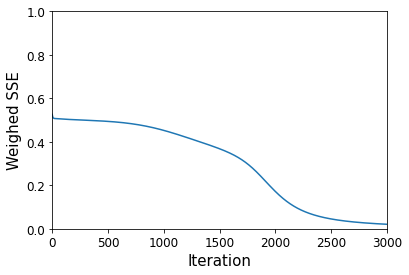

In [45]:
# the data
# change between data_OR and data_XOR based on what you want to learn
data = data_XOR

# shuffle data
np.random.shuffle(data.values)
X = data[['x1', 'x2']].values
y = data[['y']].values
input_size = X.shape[1]

# initialize the MLP
mlp = MLP(n_input = input_size, 
          n_hidden = 5, # number of hidden layers
          n_output = 1) # number of outputnodes

# train the MLP on the dataset
errors = mlp.train(X, y, 
                   learn_rate = 0.2,
                   maxit = 3000) # number of training epochs

# make predictions on the training dataset
predictions = np.array([mlp.predict(X[i, ]) for i in range(len(X))])

# compute final accuracy
accuracy = sum((predictions > 0.5).astype(int) == y) / len(y)
print('Final accuracy:', accuracy)

# plot weighed SSE over iterations
plot_errors(errors, 'Weighed SSE')

As can be seen, the MLP is able to learn the pattern of the XOR dataset in 3000 training epochs with the accuracy of 1 the weighed SSE approaching 0.

## Training a MLP on EEG Data

We will now look at how well the MLP can be trained to classify data we did not create ourselves but recorded from brain activity. We will use a dataset from the [MNE](https://mne.tools/stable/index.html) library. The dataset (EEGBCI, described at [PhysioNet](https://www.physionet.org/content/eegmmidb/1.0.0/)) contains EEG recordings on various tasks, including a *motor imagery* task: subjects were instructed to imagine moving either their hands or their feet, given some visual cue. We will use the data from one participant performing this task in 45 trials (21 for hands, 24 for feet), while EEGs were recorded from 64 electrodes across the scalp. 

First, let us load the data.

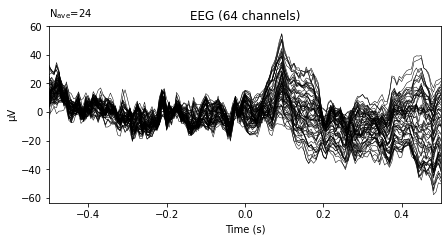

In [46]:
feet_plot = full_epochs['feet'].average().plot()

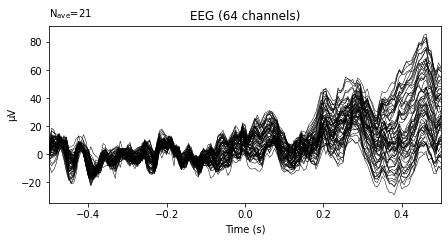

In [47]:
hands_plot = full_epochs['hands'].average().plot()

We have loaded the EEG data from 0.5 seconds before the visual cue was presented until 0.5 seconds after it was presented. The plots above show the raw EEG data for each of the 64 channels, averaged over trials, with the cue presentation at $t=0$. On the x-axis, time in seconds (s) can be seen; on the y-axis, the recorded signal in millivolts (mV).

We would like the MLP to learn to distinguish this pattern or, in other words, to predict from an EEG signal which extremities a subject is imaginarily moving after a signal has been introduced. For this purpose, we will only use the signals where the subject was actually imagining the movement ($t=0$). Furthermore, we don’t use all data points in the raw EEG signal; instead, we compute some features with which we aim to capture the most critical information about the wave.

We intend to capture some of the temporal properties of the EEG signal (how the wave changes over time), as well as some spectral properties (how intense the signal is in different frequency bands). 

For the *temporal properties*, we divide the y-axis range of the EEG signal into three quantiles (in the plot below, the regions are divided by the grey horizontal lines). From every raw EEG wave (the black line), we first remove the noise (giving the blue line) and then compute the average of the transformed signal at a few evenly spread points (blue dots). For each of those dots, we add a 0, 1, or 2 to our list of features depending on what quantile they fall in. Hence, the list of temporal features encoding the signal below would be `[0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2]`. The quantiles are computed separately for each channel of every epoch, such that there will be an approximately equal number of points in each of the three ranges — the 0s, 1s, and 2s, therefore encode the _relative_ upward and downward movement of the wave over time.

<img src="https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/tempf.png" alt="Temporal feature extraction" width="800"/>

For the *spectral properties*, we look at three different frequency bands: theta (3.5 - 7.5 Hz), alpha (7.5 - 13 Hz), and beta (14+ Hz). We want to encode the relative distribution of spectral power density in these three bands: which frequency band contains the most movement and which the least? Again, we encode this using 0, 1, and 2, but this time, the numbers mean “least,” “middle,” and “most” spectral power density. The plot below shows the spectral power density for different frequency ranges across the entire signal timeframe. The alpha band has the highest power density for this signal, followed by theta and beta. The list of spectral features encoding this signal would therefore be `[1, 2, 0]`.

<img src="https://raw.githubusercontent.com/clclab/FNCM/main/book/Lab4-materials/img/specf.png" alt="Spectral feature extraction" width="800"/>

Ultimately, we select the best of all spectral and temporal features across trials, such that we end up with a list of 96 numbers (all 0s, 1s, and 2s) encoding the EEG signal per trial. More information about the feature extraction and selection procedure can be found in the `EEG.py`.

This is all information we need for the MLP to learn to distinguish between imagined hand or foot movements.




We split the data into a training and a test set to see how well the MLP model can learn to do the classification. We will train the model on two-thirds of the data and then test its prediction accuracy on the other third. As such, we evaluate how well the learned decision boundary (in this case, a many-dimensional hypersurface) will generalize to correctly classify unseen data.

In [48]:
# shuffle data
idx = list(range(len(EEG_imagery['trial_numbers'])))
random.shuffle(idx)
EEG_imagery['trial_numbers'] = EEG_imagery['trial_numbers'][idx]
EEG_imagery['features'] = EEG_imagery['features'][idx]
EEG_imagery['labels'] = EEG_imagery['labels'][idx]

# split 2/3 to train & test set
trials_train = EEG_imagery['trial_numbers'][ : 30]
trials_test = EEG_imagery['trial_numbers'][30 : ]
X_train = EEG_imagery['features'][ : 30]
X_test = EEG_imagery['features'][30 : ]
y_train = EEG_imagery['labels'][ : 30]
y_test = EEG_imagery['labels'][30 : ]

The code block below trains the MLP, plots the error over training, and prints the final accuracy on the test set.

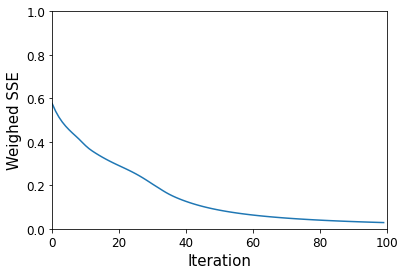

Final accuracy: 0.7333333333333333


In [55]:
# train MLP & plot training error
mlp = MLP(n_input = 96, 
          n_hidden = 5, 
          n_output = 1)

errors = mlp.train(X_train, y_train, 
                   maxit = 100, learn_rate = 0.1)

plot_errors(errors, 'Weighed SSE')

# make predictions on test set
predictions = np.array([mlp.predict(X_test[i]) for i in range(len(X_test))]).flatten()
accurate = ((predictions > 0.5).astype(int) == y_test)
accuracy = sum(accurate) / len(y_test)
print('Final accuracy:', accuracy)

As can be seen, the MLP can learn how to distinguish between imagined hand or foot movements with an average accuracy of 0.7 and the weighed SSE approaching 0.

The cells below plot the EEG trials assigned to the _training set_, i.e., the epochs based on which the MLP learned to distinguish hands vs. feet in the motor imagery data. Note that the epochs here are cropped from the moment of cue presentation $(t = 0)$. We again separately plot the training set epochs (averaged over trials) for imagined feet movement vs. imagined hand movement.

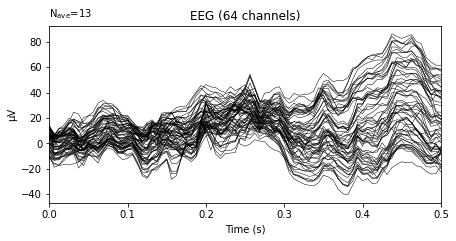

In [ ]:
# Plot epochs in training set for feet (labeled 0)
feet_trials = trials_train[np.where(y_train == 0)]
train_feet_plot = cropped_epochs[feet_trials].average().plot()

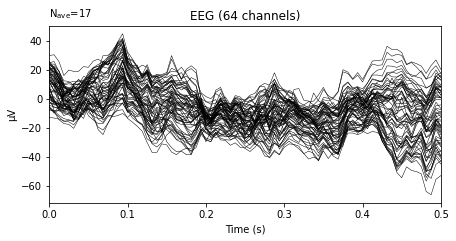

In [ ]:
# Plot epochs in training set for hands (labeled 1)
hands_trials = trials_train[np.where(y_train == 1)]
train_hands_plot = cropped_epochs[hands_trials].average().plot()

Now, for which _unseen_ epochs did the MLP not manage to make a correct prediction? The code below separately plots the EEG data for each _misclassified_ trial in the _test set_.

Trial: 13
Prediction: 0
Correct label: 1


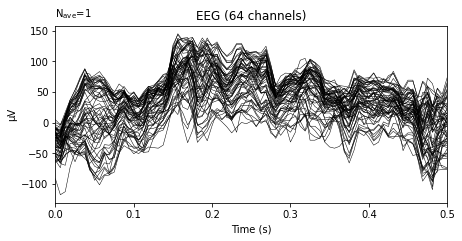

Trial: 3
Prediction: 0
Correct label: 1


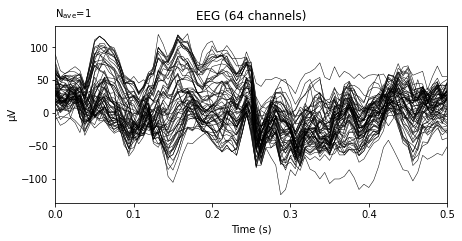

Trial: 34
Prediction: 1
Correct label: 0


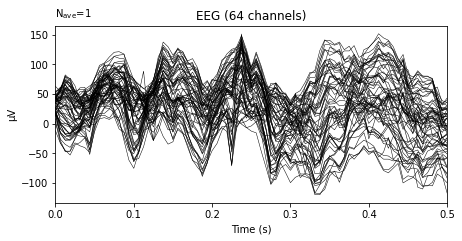

Trial: 28
Prediction: 1
Correct label: 0


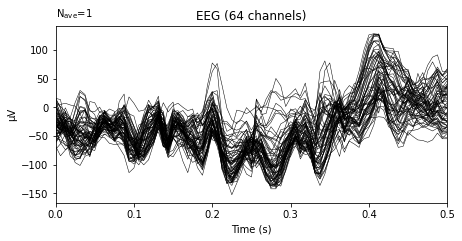

In [56]:
prediction_mistakes = np.where(accurate == False)[0]
for idx in prediction_mistakes:
    print('Trial:', trials_test[idx])
    print('Prediction:', (predictions[idx] > 0.5).astype(int))
    print('Correct label:', y_test[idx])
    cropped_epochs[trials_test[idx]].average().plot()

The question now is why the MLP made a mistake in classifying the movement.